# Analisis de Frecuencia

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

from sklearn.cluster import KMeans

## Data Wrangling

In [139]:
host='localhost'
db='RFM_unifin'
user_db='root'
pass_db=''

conn=pymysql.connect(host=host, user=user_db, passwd=pass_db, db=db)

cur=conn.cursor()

query="SELECT Cuenta,Last_date,Num_Tickets,Monto FROM Transacciones;"

cur.execute(query),

res = cur.fetchall()

cur.close()

conn.close()

headers=['Id','Date','Frecuency','Money']

id_RFM=headers[0]
target_R=headers[1]
target_F=headers[2]
target_M=headers[3]


dataset_dummy={}
filas=0

for h in headers:
    dataset_dummy[h]=[]
    
if(len(res)>0):
    for r in res:
        filas+=1
        for i in range(len(headers)):
            dataset_dummy[headers[i]].append(r[i])

print('El numero de filas de este dataset es de:'+str(filas))

dataset=pd.DataFrame(dataset_dummy)#convertir diccionario en dataset
dataset[target_R]=dataset[target_R].astype(str).str.replace('-', '')
dataset[target_R]=dataset[target_R].astype(str).astype(int)
    
dataset.head()  

El numero de filas de este dataset es de:998


,Cuenta,Date,Frecuency,Money
0,1,2015-12-16,10,1000.0
1,2,2015-12-14,2,490.0
2,3,2015-12-13,7,287.0
3,4,2015-12-12,4,259.0
4,5,2015-12-11,6,866.0


**-------------------------------------------------------------------------------------------------------------**

In [140]:
print(dataset.shape)
print(dataset.dtypes)

dataset=dataset.sort_values(by=target_F,ascending=True)
dataset = dataset.reset_index(drop=True)
dataset.head()

(998, 4)
Cuenta                int64
Date         datetime64[ns]
Frecuency             int64
Money               float64
dtype: object


,Cuenta,Date,Frecuency,Money
0,337,2015-01-13,1,711.0
1,392,2014-11-19,1,826.0
2,967,2013-04-23,1,332.0
3,940,2013-05-20,1,230.0
4,968,2013-04-22,1,78.0


In [141]:
#Normalizacion de Dataset
#se mecesitan todas la variables numericas
#dataset_norm=(dataset-dataset.min())/(dataset.max()-dataset.min())
#dataset_norm.head()

## Creacion y ajustes de Clusters

In [142]:
model_f=KMeans(n_clusters=5).fit(dataset[[target_F]])
clust_f=pd.Series(model_f.labels_)
dataset['p_f']=clust_f
dataset.head()

,Cuenta,Date,Frecuency,Money,p_f
0,337,2015-01-13,1,711.0,4
1,392,2014-11-19,1,826.0,4
2,967,2013-04-23,1,332.0,4
3,940,2013-05-20,1,230.0,4
4,968,2013-04-22,1,78.0,4


In [143]:
lim_clusts=[]
for i in range(0,5):
    x=dataset[dataset['p_f']==i]
    lim_clusts.append(x[target_F].max())
lim_clusts.sort()   

print(lim_clusts)

[2, 4, 6, 8, 10]


In [144]:
lim1=lim_clusts[0]
lim2=lim_clusts[1]
lim3=lim_clusts[2]
lim4=lim_clusts[3]
lim5=lim_clusts[4]

print(lim1)
print(lim2)
print(lim3)
print(lim4)
print(lim5)

2
4
6
8
10


In [145]:
dataset.loc[(dataset[target_F] <= lim1), 'F'] = 1
dataset.loc[(dataset[target_F] <= lim2) & (dataset[target_F] > lim1), 'F'] = 2
dataset.loc[(dataset[target_F] <= lim3) & (dataset[target_F] > lim2), 'F'] = 3
dataset.loc[(dataset[target_F] <= lim4) & (dataset[target_F] > lim3), 'F'] = 4
dataset.loc[(dataset[target_F] <= lim5) & (dataset[target_F] > lim4), 'F'] = 5

dataset=dataset.drop(['p_f'], axis=1)

dataset.head()

,Cuenta,Date,Frecuency,Money,F
0,337,2015-01-13,1,711.0,1.0
1,392,2014-11-19,1,826.0,1.0
2,967,2013-04-23,1,332.0,1.0
3,940,2013-05-20,1,230.0,1.0
4,968,2013-04-22,1,78.0,1.0


## Actualizacion de DB

In [146]:
#conn=pymysql.connect(host=host, user=user_db, passwd=pass_db, db=db)

#cur=conn.cursor()
#for index,row in dataset.iterrows():
#	query="Update Transacciones set F="+str(int(row['F']))+" where Cuenta="+str(int(row[id_RFM]))+";"
#	cur.execute(query)

#conn.commit()
#cur.close()
#conn.close()

## Conclusion

In [147]:
d=dataset['F'].value_counts().to_dict()
f_frame=pd.DataFrame([d], columns=d.keys())
f_frame

,5.0,4.0,1.0,3.0,2.0
0,215,210,201,186,186


[]

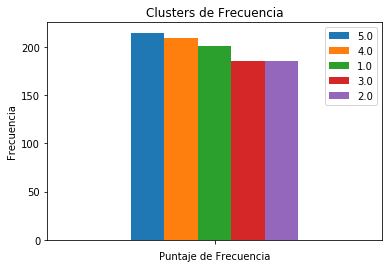

In [148]:
ax=f_frame.plot(kind='bar')
ax.set_title('Clusters de Frecuencia')
ax.set_xlabel('Puntaje de Frecuencia')
ax.set_ylabel('Frecuencia')
ax.set_xticklabels('')

Text(0.5, 1.0, 'Distribuicion de frecuencias y Clusters')

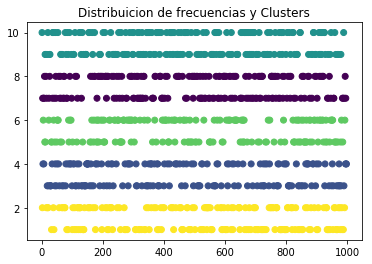

In [149]:
plt.scatter(x=dataset[id_RFM],y=dataset[target_F],c=clust_f)
plt.title('Distribuicion de frecuencias y Clusters')

In [150]:
for i in f_frame.columns.values:
    x=dataset[dataset['F']==i]
    print('Para el Cluster con valor en F=',i)
    print('Las Frecuencias van de ',x[target_F].min(),' a ',x[target_F].max())
    print('')

Para el Cluster con valor en F= 5.0
Las Frecuencias van de  9  a  10

Para el Cluster con valor en F= 4.0
Las Frecuencias van de  7  a  8

Para el Cluster con valor en F= 1.0
Las Frecuencias van de  1  a  2

Para el Cluster con valor en F= 3.0
Las Frecuencias van de  5  a  6

Para el Cluster con valor en F= 2.0
Las Frecuencias van de  3  a  4

